In [44]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [45]:
def stock_predictor(ticker,start,end):
    
    df = web.DataReader(ticker, data_source='yahoo', start=start, end=end)
    print('_'*100)
    print('Number of days:',df.shape[0])
    
    plt.figure(figsize = (16,8))
    plt.title('Closed Price History')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Closed Price', fontsize=18)
    plt.show()
    
    # creating a new dataframe only with close price column
    newdf = df.filter(['Close'])
    
    dataset = newdf.values
    
    training_data_len = math.ceil( len(dataset) *0.8)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    scaled_data = scaler.fit_transform(dataset)
    
    train_data = scaled_data[0:training_data_len, :]
    
    x_train = [] # independent data
    y_train = [] # dependent data, deends on x_train
    
    for data in range(60, len(train_data)):
        x_train.append(train_data[data-60:data, 0])
        y_train.append(train_data[data,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    print('LSTM Fitting:')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    
    test_data = scaled_data[training_data_len-60: , :]
    
    x_test = []
    y_test = dataset[training_data_len:, :]
    
    for tdata in range(60, len(test_data)):
        x_test.append(test_data[tdata-60:tdata, 0])
        
    x_test = np.array(x_test)
    
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # model predicted price
    
    predictions = model.predict(x_test)
    
    # inverse transform the data 
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt( np.mean(predictions - y_test)**2)
    print('_'*100)

    print('Root Mean Squared Error:',rmse)
    
    train = newdf[:training_data_len]
    # validation dataset
    valid = newdf[training_data_len:]
    valid['predictions'] = predictions
    # visualizing the data
    plt.figure(figsize=(16, 8))
    plt.title('Model Visualization')
    plt.xlabel('Data', fontsize=18)
    plt.ylabel('Closed Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'predictions']])
    plt.legend(['train', 'validation', 'prediction'], loc='lower right')
    plt.show()
    return


____________________________________________________________________________________________________
Number of days: 755


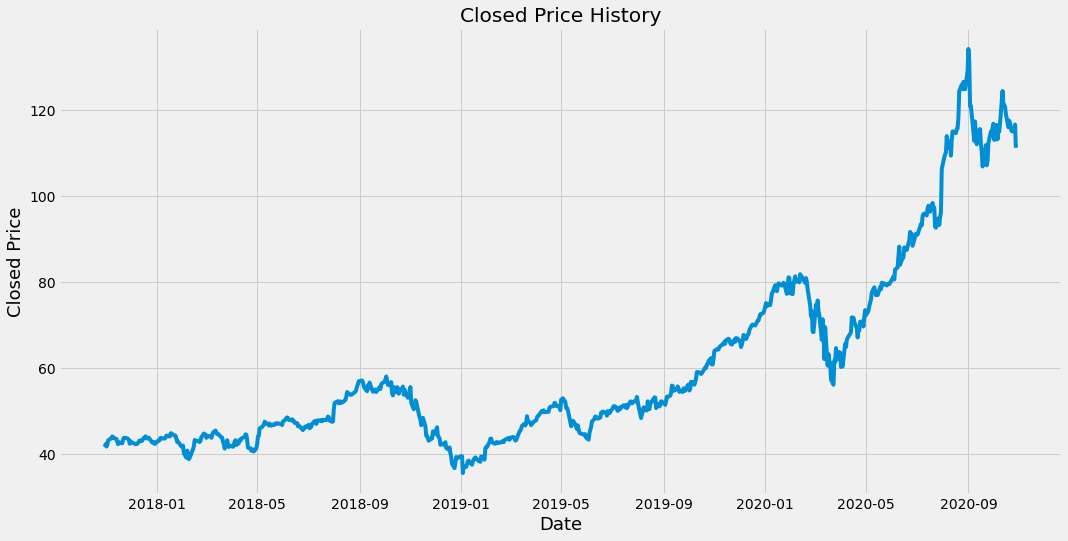

LSTM Fitting:
Epoch 1/1
544/544 [==============================] - 36s 67ms/step - loss: 0.0011
____________________________________________________________________________________________________
Root Mean Squared Error: 3.5649390568006907


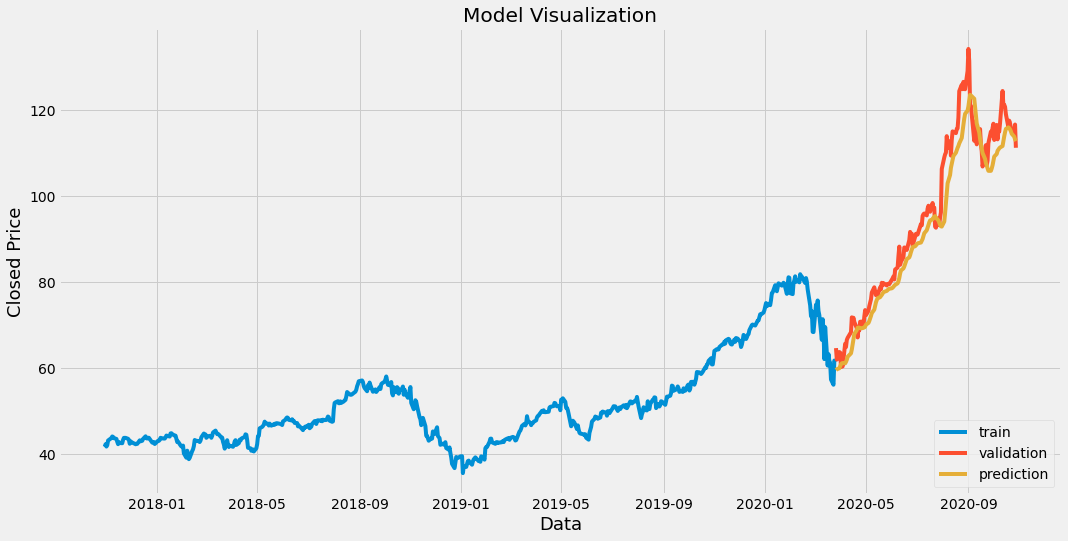

In [47]:
stock_predictor('AAPL',start= '2017-10-28',end = '2020-10-28')